In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import logging
from functools import partial

import jax
from jax import random
from jax import numpy as jnp
import wandb
import matplotlib
import matplotlib.pyplot as plt

from src.models import make_PoG_Ens_loss as make_loss
from src.models import make_PoG_Ens_plots as make_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.toy_pog_ens import get_config
from src.models.pog import calculate_pog_loc_scale

In [6]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_pon_ens.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


True

In [7]:
rng = random.PRNGKey(0)

In [8]:
config = get_config()

In [9]:
data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

In [10]:
setup_rng, rng = random.split(rng)
init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

model, state = setup_training(config, setup_rng, init_x, init_y)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 1.30555, val_loss: 1.83534, β: 2.2, lr: 0.00010


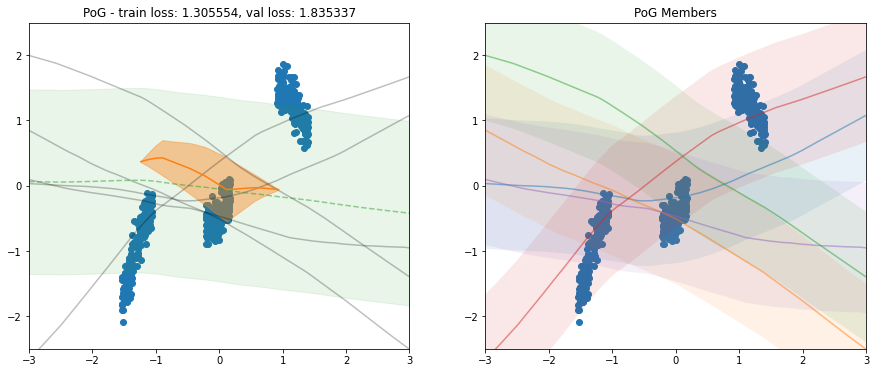

epoch:   2 - train loss: 1.20522, val_loss: 1.84540, β: 2.2, lr: 0.00010
epoch:   3 - train loss: 1.18281, val_loss: 1.85322, β: 2.2, lr: 0.00010
epoch:   4 - train loss: 1.15101, val_loss: 1.85871, β: 2.2, lr: 0.00010
epoch:   5 - train loss: 1.10798, val_loss: 1.86190, β: 2.2, lr: 0.00010
epoch:   6 - train loss: 1.06717, val_loss: 1.86285, β: 2.3, lr: 0.00010
epoch:   7 - train loss: 1.02650, val_loss: 1.86159, β: 2.3, lr: 0.00010
epoch:   8 - train loss: 0.98453, val_loss: 1.85787, β: 2.3, lr: 0.00010
epoch:   9 - train loss: 0.94233, val_loss: 1.85182, β: 2.3, lr: 0.00010
epoch:  10 - train loss: 0.90060, val_loss: 1.84386, β: 2.3, lr: 0.00010
epoch:  11 - train loss: 0.85964, val_loss: 1.83455, β: 2.3, lr: 0.00010
epoch:  12 - train loss: 0.81980, val_loss: 1.82365, β: 2.3, lr: 0.00010
epoch:  13 - train loss: 0.78131, val_loss: 1.81114, β: 2.4, lr: 0.00010
epoch:  14 - train loss: 0.74389, val_loss: 1.79774, β: 2.4, lr: 0.00010
epoch:  15 - train loss: 0.70945, val_loss: 1.78344

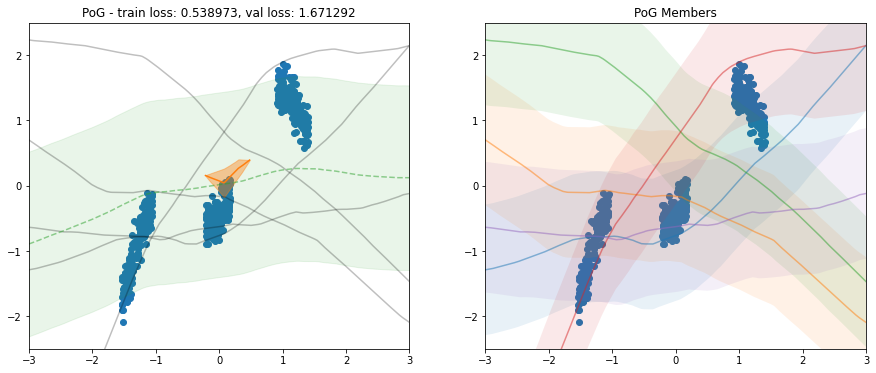

epoch:  22 - train loss: 0.51511, val_loss: 1.64858, β: 2.6, lr: 0.00010
epoch:  23 - train loss: 0.49250, val_loss: 1.62603, β: 2.6, lr: 0.00010
epoch:  24 - train loss: 0.47106, val_loss: 1.60411, β: 2.6, lr: 0.00010
epoch:  25 - train loss: 0.45109, val_loss: 1.58302, β: 2.7, lr: 0.00010
epoch:  26 - train loss: 0.43147, val_loss: 1.56312, β: 2.7, lr: 0.00010
epoch:  27 - train loss: 0.41203, val_loss: 1.54518, β: 2.7, lr: 0.00010
epoch:  28 - train loss: 0.39297, val_loss: 1.52985, β: 2.8, lr: 0.00010
epoch:  29 - train loss: 0.37394, val_loss: 1.51757, β: 2.8, lr: 0.00010
epoch:  30 - train loss: 0.35480, val_loss: 1.50934, β: 2.8, lr: 0.00010
epoch:  31 - train loss: 0.33441, val_loss: 1.50614, β: 2.9, lr: 0.00010
epoch:  32 - train loss: 0.31427, val_loss: 1.50841, β: 2.9, lr: 0.00010
epoch:  33 - train loss: 0.29419, val_loss: 1.51729, β: 3.0, lr: 0.00010
epoch:  34 - train loss: 0.27295, val_loss: 1.53406, β: 3.0, lr: 0.00010
epoch:  35 - train loss: 0.25065, val_loss: 1.55968

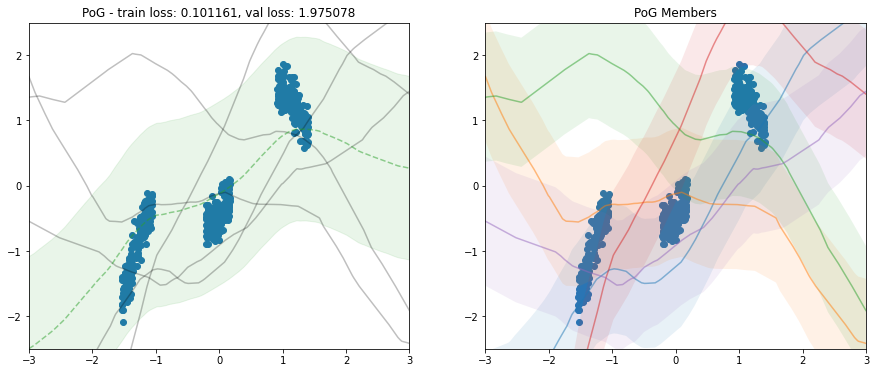

epoch:  42 - train loss: 0.07173, val_loss: 2.09365, β: 3.5, lr: 0.00010
epoch:  43 - train loss: 0.04065, val_loss: 2.22346, β: 3.5, lr: 0.00010
epoch:  44 - train loss: 0.00796, val_loss: 2.36076, β: 3.6, lr: 0.00010
epoch:  45 - train loss: -0.02615, val_loss: 2.50535, β: 3.7, lr: 0.00010
epoch:  46 - train loss: -0.06131, val_loss: 2.65161, β: 3.8, lr: 0.00010
epoch:  47 - train loss: -0.09702, val_loss: 2.79219, β: 3.9, lr: 0.00010
epoch:  48 - train loss: -0.13134, val_loss: 2.91976, β: 4.0, lr: 0.00010
epoch:  49 - train loss: -0.16038, val_loss: 3.01555, β: 4.1, lr: 0.00010
epoch:  50 - train loss: -0.17895, val_loss: 3.07508, β: 4.1, lr: 0.00010
epoch:  51 - train loss: -0.18791, val_loss: 3.08530, β: 4.2, lr: 0.00010
epoch:  52 - train loss: -0.19429, val_loss: 3.05835, β: 4.4, lr: 0.00010
epoch:  53 - train loss: -0.20235, val_loss: 3.00722, β: 4.5, lr: 0.00010
epoch:  54 - train loss: -0.21087, val_loss: 2.97069, β: 4.6, lr: 0.00010
epoch:  55 - train loss: -0.21304, val_lo

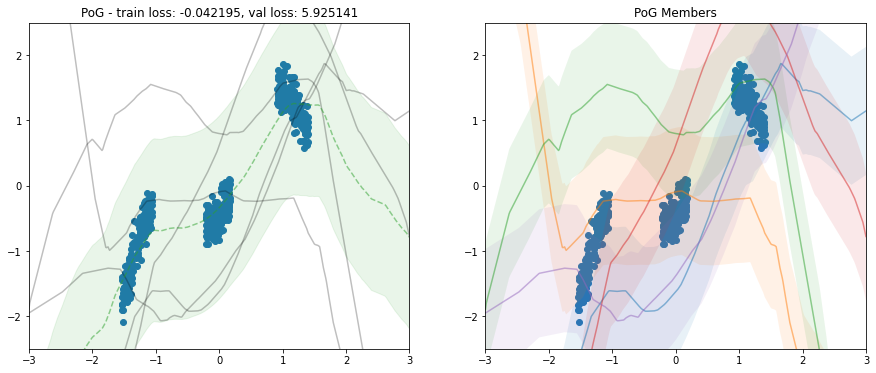

epoch:  62 - train loss: 0.00961, val_loss: 5.02194, β: 5.7, lr: 0.00010
epoch:  63 - train loss: 0.03997, val_loss: 3.87169, β: 5.9, lr: 0.00010
epoch:  64 - train loss: 0.07011, val_loss: 3.02025, β: 6.0, lr: 0.00010
epoch:  65 - train loss: 0.10054, val_loss: 2.57509, β: 6.2, lr: 0.00010
epoch:  66 - train loss: 0.10084, val_loss: 2.39720, β: 6.4, lr: 0.00010
epoch:  67 - train loss: 0.07489, val_loss: 2.32731, β: 6.6, lr: 0.00010
epoch:  68 - train loss: 0.04123, val_loss: 2.31226, β: 6.8, lr: 0.00010
epoch:  69 - train loss: 0.00043, val_loss: 2.32760, β: 7.0, lr: 0.00010
epoch:  70 - train loss: -0.03825, val_loss: 2.37173, β: 7.2, lr: 0.00010
epoch:  71 - train loss: -0.06507, val_loss: 2.44413, β: 7.4, lr: 0.00010
epoch:  72 - train loss: -0.08182, val_loss: 2.55128, β: 7.6, lr: 0.00010
epoch:  73 - train loss: -0.09095, val_loss: 2.63856, β: 7.8, lr: 0.00010
epoch:  74 - train loss: -0.09156, val_loss: 2.71478, β: 8.1, lr: 0.00010
epoch:  75 - train loss: -0.09068, val_loss: 2

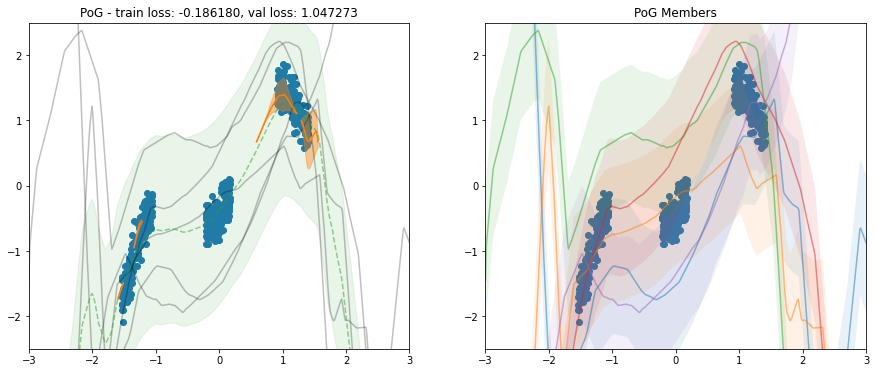

epoch:  82 - train loss: -0.21399, val_loss: 0.98401, β: 10.2, lr: 0.00010
epoch:  83 - train loss: -0.23753, val_loss: 0.94360, β: 10.5, lr: 0.00010
epoch:  84 - train loss: -0.25452, val_loss: 0.92984, β: 10.9, lr: 0.00010
epoch:  85 - train loss: -0.26489, val_loss: 0.91392, β: 11.2, lr: 0.00010
epoch:  86 - train loss: -0.27028, val_loss: 0.88748, β: 11.5, lr: 0.00010
epoch:  87 - train loss: -0.27368, val_loss: 0.84422, β: 11.8, lr: 0.00010
epoch:  88 - train loss: -0.27542, val_loss: 0.71419, β: 12.1, lr: 0.00010
epoch:  89 - train loss: -0.27482, val_loss: 0.52686, β: 12.5, lr: 0.00010
epoch:  90 - train loss: -0.27422, val_loss: 0.32658, β: 12.8, lr: 0.00010
epoch:  91 - train loss: -0.27434, val_loss: 0.18842, β: 13.2, lr: 0.00010
epoch:  92 - train loss: -0.27242, val_loss: 0.09939, β: 13.5, lr: 0.00010
epoch:  93 - train loss: -0.27058, val_loss: 0.05100, β: 13.9, lr: 0.00010
epoch:  94 - train loss: -0.26859, val_loss: 0.02713, β: 14.2, lr: 0.00010
epoch:  95 - train loss: 

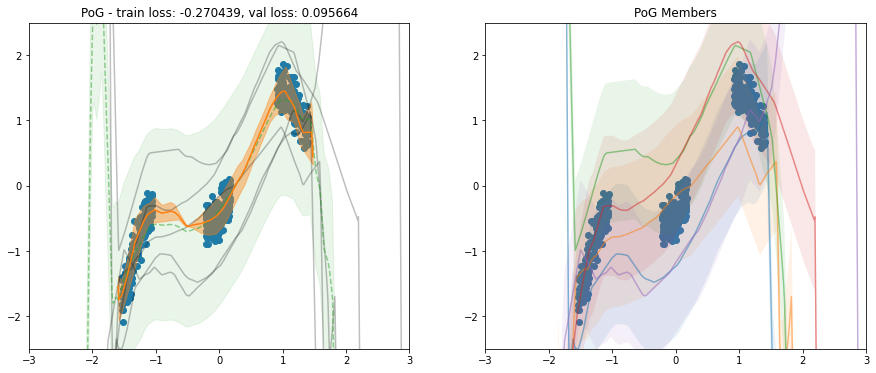

epoch: 102 - train loss: -0.27201, val_loss: 0.13541, β: 17.2, lr: 0.00010
epoch: 103 - train loss: -0.27339, val_loss: 0.18630, β: 17.6, lr: 0.00010
epoch: 104 - train loss: -0.27442, val_loss: 0.25177, β: 17.9, lr: 0.00010
epoch: 105 - train loss: -0.27531, val_loss: 0.33119, β: 18.3, lr: 0.00010
epoch: 106 - train loss: -0.27566, val_loss: 0.41763, β: 18.7, lr: 0.00010
epoch: 107 - train loss: -0.27565, val_loss: 0.50156, β: 19.0, lr: 0.00010
epoch: 108 - train loss: -0.27652, val_loss: 0.58243, β: 19.4, lr: 0.00010
epoch: 109 - train loss: -0.27744, val_loss: 0.66909, β: 19.8, lr: 0.00010
epoch: 110 - train loss: -0.27675, val_loss: 0.74832, β: 20.1, lr: 0.00010
epoch: 111 - train loss: -0.27510, val_loss: 0.79780, β: 20.5, lr: 0.00010
epoch: 112 - train loss: -0.27304, val_loss: 0.77481, β: 20.8, lr: 0.00010
epoch: 113 - train loss: -0.27137, val_loss: 0.66578, β: 21.2, lr: 0.00010
epoch: 114 - train loss: -0.27178, val_loss: 0.53129, β: 21.5, lr: 0.00010
epoch: 115 - train loss: 

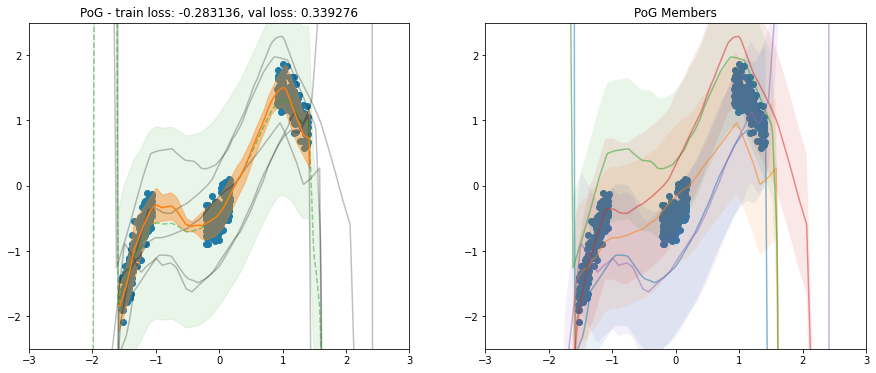

epoch: 122 - train loss: -0.28304, val_loss: 0.34391, β: 24.0, lr: 0.00010
epoch: 123 - train loss: -0.28335, val_loss: 0.35302, β: 24.3, lr: 0.00010
epoch: 124 - train loss: -0.28360, val_loss: 0.37084, β: 24.6, lr: 0.00010
epoch: 125 - train loss: -0.28354, val_loss: 0.39910, β: 24.9, lr: 0.00010
epoch: 126 - train loss: -0.28337, val_loss: 0.43517, β: 25.2, lr: 0.00010
epoch: 127 - train loss: -0.28320, val_loss: 0.47145, β: 25.4, lr: 0.00010
epoch: 128 - train loss: -0.28238, val_loss: 0.49869, β: 25.7, lr: 0.00010
epoch: 129 - train loss: -0.28179, val_loss: 0.51272, β: 25.9, lr: 0.00010
epoch: 130 - train loss: -0.28171, val_loss: 0.51781, β: 26.2, lr: 0.00010
epoch: 131 - train loss: -0.28201, val_loss: 0.52122, β: 26.4, lr: 0.00010
epoch: 132 - train loss: -0.28212, val_loss: 0.52916, β: 26.6, lr: 0.00010
epoch: 133 - train loss: -0.28195, val_loss: 0.54601, β: 26.8, lr: 0.00010
epoch: 134 - train loss: -0.28192, val_loss: 0.57536, β: 27.0, lr: 0.00010
epoch: 135 - train loss: 

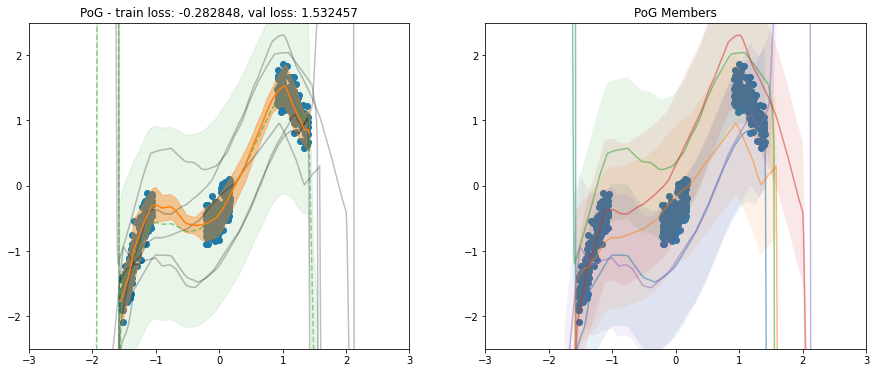

epoch: 142 - train loss: -0.28315, val_loss: 1.80909, β: 28.5, lr: 0.00010
epoch: 143 - train loss: -0.28348, val_loss: 2.09981, β: 28.6, lr: 0.00010
epoch: 144 - train loss: -0.28378, val_loss: 2.39639, β: 28.8, lr: 0.00010
epoch: 145 - train loss: -0.28408, val_loss: 2.70316, β: 28.9, lr: 0.00010
epoch: 146 - train loss: -0.28433, val_loss: 3.03208, β: 29.0, lr: 0.00010
epoch: 147 - train loss: -0.28456, val_loss: 3.38366, β: 29.2, lr: 0.00010
epoch: 148 - train loss: -0.28472, val_loss: 3.75254, β: 29.3, lr: 0.00010
epoch: 149 - train loss: -0.28490, val_loss: 4.12237, β: 29.4, lr: 0.00010
epoch: 150 - train loss: -0.28502, val_loss: 4.45516, β: 29.5, lr: 0.00010
epoch: 151 - train loss: -0.28514, val_loss: 4.71616, β: 29.6, lr: 0.00010
epoch: 152 - train loss: -0.28528, val_loss: 4.89120, β: 29.8, lr: 0.00010
epoch: 153 - train loss: -0.28550, val_loss: 4.99685, β: 29.9, lr: 0.00010
epoch: 154 - train loss: -0.28574, val_loss: 5.05512, β: 29.9, lr: 0.00010
epoch: 155 - train loss: 

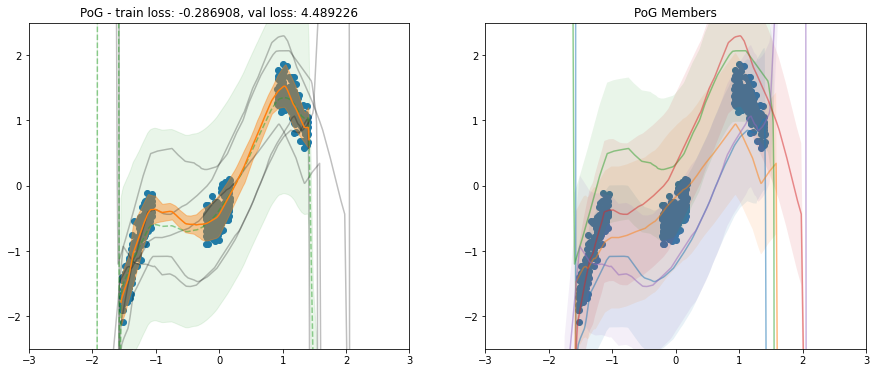

Best val_loss
epoch: 162 - train loss: -0.28711, val_loss: 4.37875, β: 30.6, lr: 0.00010
Best val_loss
epoch: 163 - train loss: -0.28727, val_loss: 4.24431, β: 30.7, lr: 0.00010
Best val_loss
epoch: 164 - train loss: -0.28743, val_loss: 4.07626, β: 30.7, lr: 0.00010
Best val_loss
epoch: 165 - train loss: -0.28761, val_loss: 3.88857, β: 30.8, lr: 0.00010
Best val_loss
epoch: 166 - train loss: -0.28774, val_loss: 3.69835, β: 30.8, lr: 0.00010
Best val_loss
epoch: 167 - train loss: -0.28789, val_loss: 3.51933, β: 30.9, lr: 0.00010
Best val_loss
epoch: 168 - train loss: -0.28801, val_loss: 3.35765, β: 30.9, lr: 0.00010
Best val_loss
epoch: 169 - train loss: -0.28814, val_loss: 3.21058, β: 31.0, lr: 0.00010
Best val_loss
epoch: 170 - train loss: -0.28824, val_loss: 3.07697, β: 31.0, lr: 0.00010
Best val_loss
epoch: 171 - train loss: -0.28834, val_loss: 2.95591, β: 31.1, lr: 0.00010
Best val_loss
epoch: 172 - train loss: -0.28845, val_loss: 2.85288, β: 31.1, lr: 0.00010
Best val_loss
epoch: 

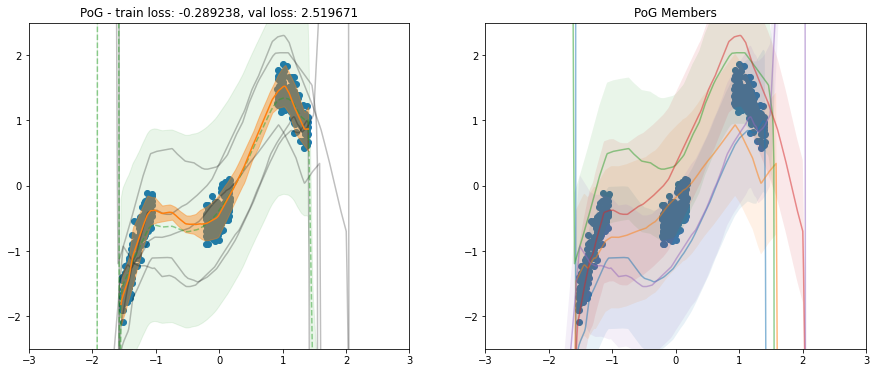

Best val_loss
epoch: 182 - train loss: -0.28928, val_loss: 2.51650, β: 31.5, lr: 0.00010
Best val_loss
epoch: 183 - train loss: -0.28936, val_loss: 2.52107, β: 31.5, lr: 0.00010
epoch: 184 - train loss: -0.28940, val_loss: 2.53441, β: 31.5, lr: 0.00010
epoch: 185 - train loss: -0.28945, val_loss: 2.55018, β: 31.5, lr: 0.00010
epoch: 186 - train loss: -0.28951, val_loss: 2.56472, β: 31.6, lr: 0.00010
epoch: 187 - train loss: -0.28959, val_loss: 2.57938, β: 31.6, lr: 0.00010
epoch: 188 - train loss: -0.28965, val_loss: 2.59503, β: 31.6, lr: 0.00010
epoch: 189 - train loss: -0.28972, val_loss: 2.61236, β: 31.6, lr: 0.00010
epoch: 190 - train loss: -0.28970, val_loss: 2.62823, β: 31.6, lr: 0.00010
epoch: 191 - train loss: -0.28973, val_loss: 2.64530, β: 31.7, lr: 0.00010
epoch: 192 - train loss: -0.28983, val_loss: 2.66536, β: 31.7, lr: 0.00010
epoch: 193 - train loss: -0.28990, val_loss: 2.68786, β: 31.7, lr: 0.00010
epoch: 194 - train loss: -0.28992, val_loss: 2.71813, β: 31.7, lr: 0.000

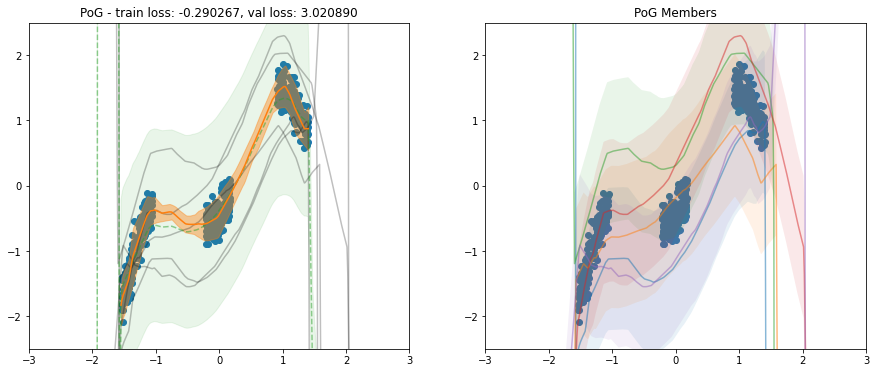

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▇▆▆▅▄▄▃▃▂▁▁▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,▄▄▄▃▃▃▃▃▄▅▅▆█▄▅▃▂▂▁▁▁▂▂▁▁▂▂▂▄▆██▇▆▅▅▄▅▅▅
β,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇▇██████████
best_epoch,182
best_val_loss,2.5165
epoch,201
learning_rate,0.0001
train/loss,-0.29027
val/loss,3.02089


In [11]:
state, best_state = train_loop(
    model, state, config, rng, make_loss, make_loss, train_loader, val_loader,
    # test_loader,
    wandb_kwargs={
        'mode': 'offline',
        # 'notes': '',
    },
    plot_fn=make_plots,
)

## Paper Plots

In [12]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_1583782/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [15]:
xs = jnp.linspace(-2.25, 2.25, num=501)

# pog preds
pred_fun = partial(
    model.apply,
    {"params": best_state.params, **best_state.model_state},
    train=False, return_ens_preds=True,
    method=model.pred
)
_, (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(xs.reshape(-1, 1))

X_train, y_train = list(zip(*train_loader.dataset))

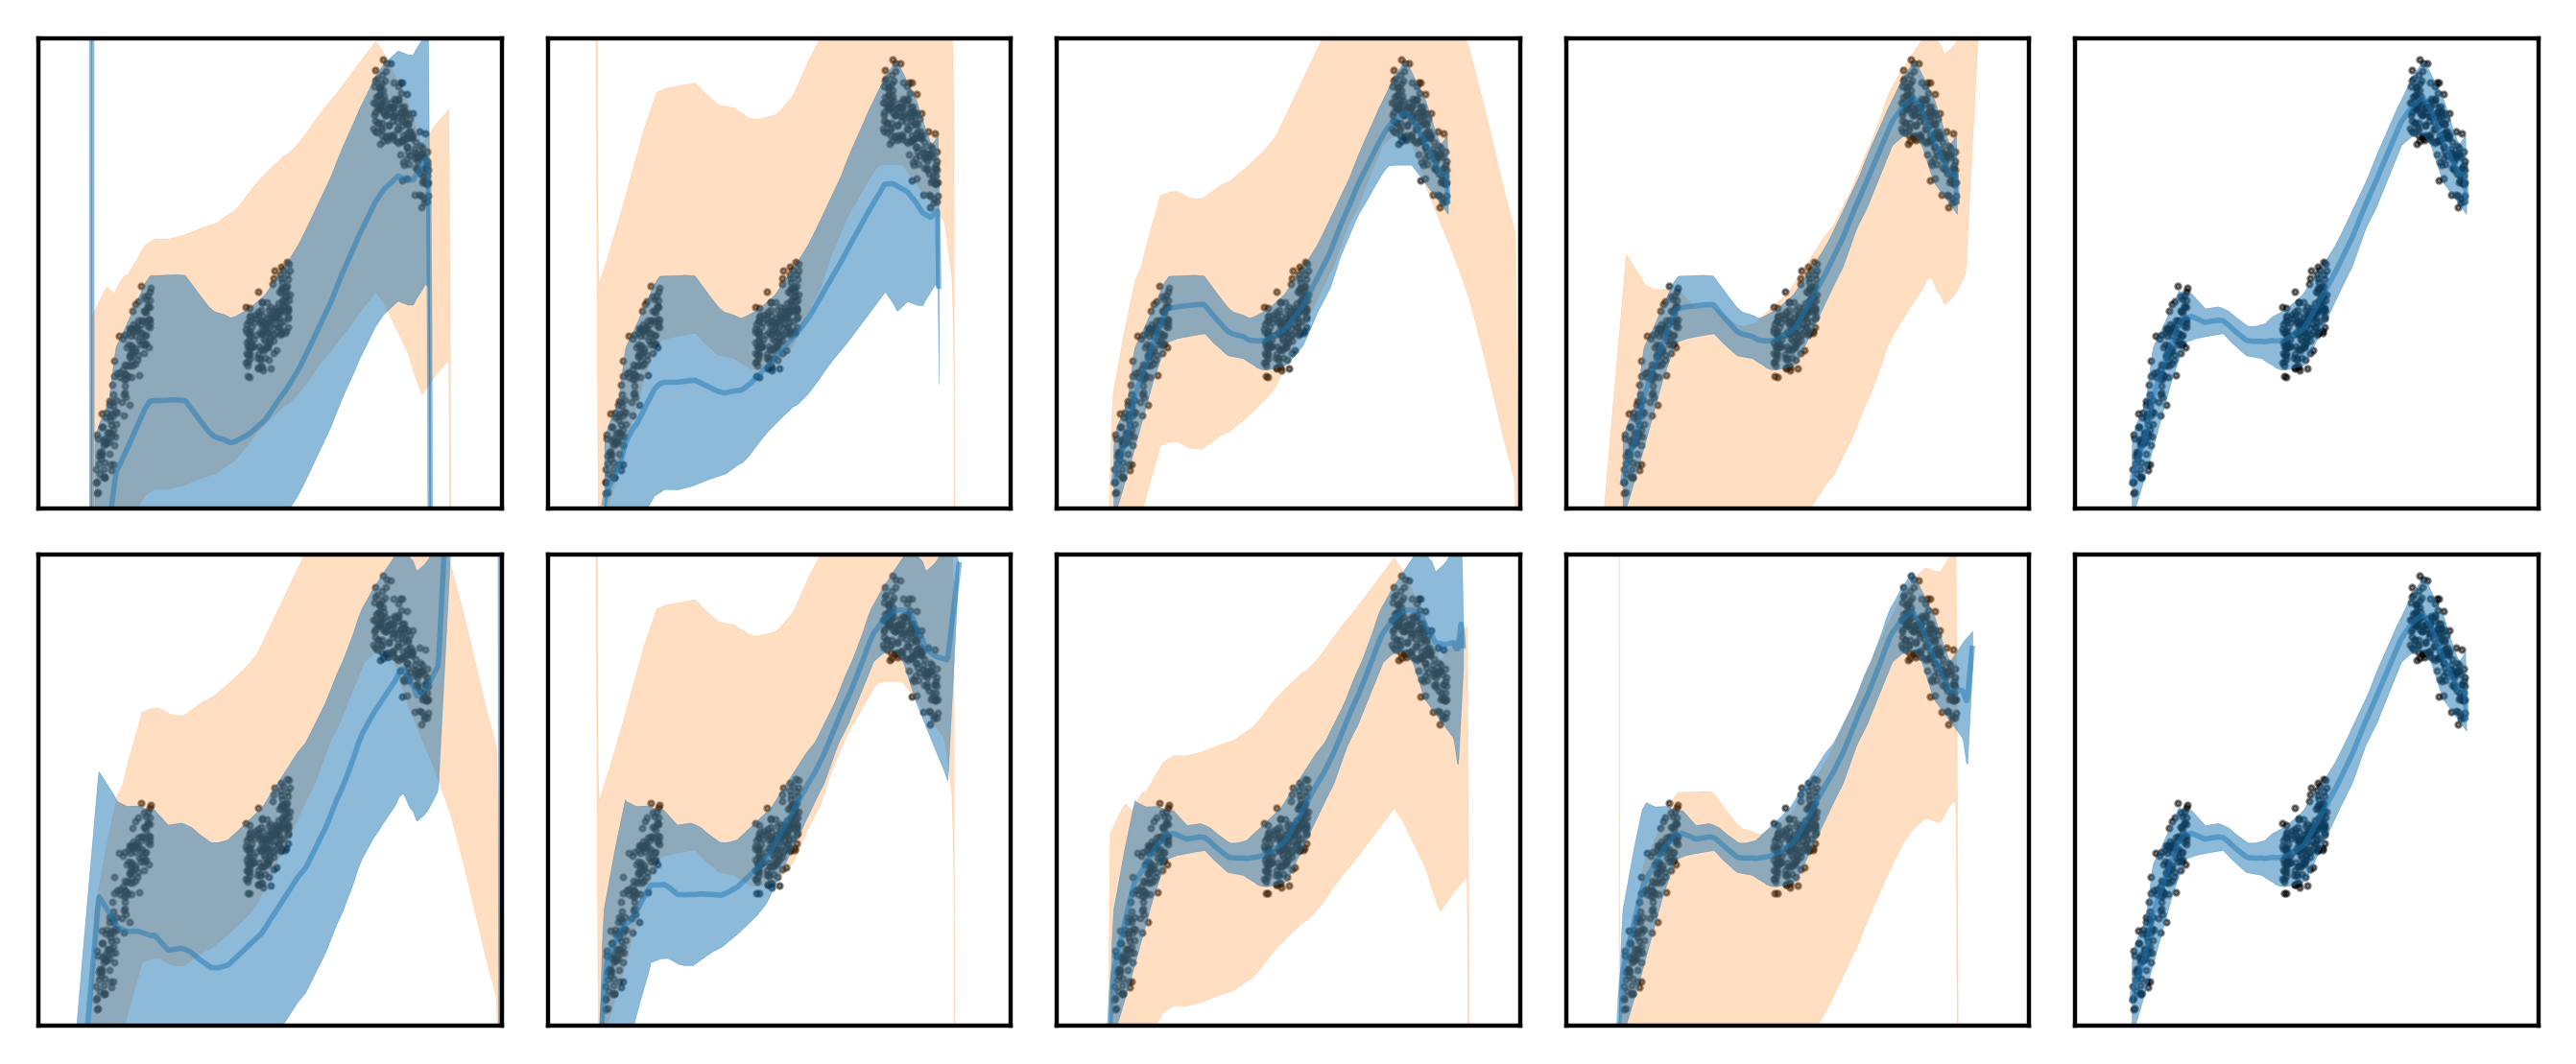

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(text_width, text_width/2.4), dpi=dpi, sharey=True, sharex=True, layout='tight')

ORDER = [jnp.array([0, 1, 2, 3, 4]), jnp.array([4, 3, 2, 1, 0])]

for r, axrow in enumerate(axs):
    for c, ax in enumerate(axrow):
        ax.scatter(X_train, y_train, c='k', s=1, lw=0.5, alpha=0.5)

        # for j in range(c + 2, config.model.size):
        #     ax.plot(xs, locs[ORDER[r][j]] + scales[ORDER[r][j]], '--', c=f'C{ORDER[r][j] + 2}', alpha=0.4, lw=0.4)
        #     ax.plot(xs, locs[ORDER[r][j]] - scales[ORDER[r][j]], '--', c=f'C{ORDER[r][j] + 2}', alpha=0.4, lw=0.4)

        if c + 1 < len(axrow):
            ax.fill_between(
                xs,
                locs[ORDER[r][c+1], :, 0] - scales[ORDER[r][c+1], :, 0],
                locs[ORDER[r][c+1], :, 0] + scales[ORDER[r][c+1], :, 0],
                color='C1', alpha=0.25, lw=0.1
            )

        loc, scale = calculate_pog_loc_scale(locs[ORDER[r][:c+1], :, 0], scales[ORDER[r][:c+1], :, 0])
        ax.plot(xs, loc, c='C0', lw=1, alpha=0.5)
        ax.fill_between(xs, loc - scale, loc + scale, color='C0', alpha=0.5, lw=0.1)

        ax.set_ylim(-2.05, 2.05)
        ax.set_xlim(-2.05, 2.05)
        ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        # ax.grid(0.3)

plt.savefig('toy_evolution.pdf', dpi=dpi, bbox_inches='tight')